In [85]:
from cov.covSum import covSum
from cov.covSEard import covSEard
from cov.covNoise import covNoise
from lik.loglikelihood import loglikelihood
import numpy as np
from scipy.optimize import minimize
from local_linearfit import local_linearfit
from calculate_gx import calculate_gx
from maximize_PD import maximize_PD
from JumpGP_LD import JumpGP_LD
from simulate_case import simulate_case

import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from skimage import measure

import numpy as np
from scipy.optimize import minimize
from scipy.linalg import cholesky
from scipy.stats import norm

from lik.loglikelihood import loglikelihood
from calculate_gx import calculate_gx
from cov.covSum import covSum
from cov.covSEard import covSEard
from cov.covNoise import covNoise
from lik.loglikelihood import loglikelihood

In [86]:
import numpy as np

# 随机生成 Training Inputs (x)
n = 100  # 行数
D = 2  # 列数
n_test = 1

x = np.random.randn(n, D)  # 生成 n x D 的随机矩阵
x0 = np.random.randn(n_test, D)

# 随机生成 Target Outputs (y)
y = np.random.randn(n, 1)  # 生成 n 行 1 列的随机列向量

# 随机生成 logtheta
logtheta = np.random.randn(D+2)  # 生成 D+1 维的随机向量
loglike = loglikelihood(logtheta, covSum, [covSEard, covNoise], x, y)
print(f"***loglike:{loglike}")

# 转换为 MATLAB 赋值语句
x_matlab = '\n'.join([' '.join(map(str, row)) for row in x])
y_matlab = '\n'.join(map(str, y.flatten()))
x_test_matlab = '\n'.join([' '.join(map(str, row)) for row in x0])
logtheta_matlab = ';\n'.join(map(str, logtheta))

print("MATLAB 赋值语句：")
print(f"x = [{x_matlab}];")
print(f"y = [{y_matlab}];")
print(f"x0 = [{x_test_matlab}];")
print(f"logtheta = [{logtheta_matlab}];")
print(f"loglike = loglikelihood(logtheta, cv,x,y);")


***loglike:209.51753875841325
MATLAB 赋值语句：
x = [-1.225158631852229 0.03700571886690396
-0.3605310250300522 0.7771436575213644
-0.8077893186912565 -0.11294888428782468
-1.7150432148499195 -1.0369811239378226
-0.6096603965902962 0.5070797720577044
2.1619422820069367 -0.6649885383229238
-1.2091563763526048 1.5547730146903511
-0.7408712649564935 -0.27701076659907703
0.97126746708683 1.8678675021443787
-0.19573421843461902 -0.9931543272060414
-1.556200584118978 0.40052421786163095
0.5003826491902008 0.1736282812121666
-0.5658431927414014 0.46186234920240715
0.1074965195507832 -0.3385661158119187
1.4918379335933019 1.6106089564905781
-1.3810407050260178 -2.078213642867812
1.1071443836089105 -0.1478899236681129
1.7588931745423677 1.7173826395052272
0.15597088983845306 0.161115379917849
-0.5589698640312925 -0.16517382294177915
0.18356274161905597 -1.1253981058419382
0.5778154725051887 -0.9640147055145757
-1.4854787254587336 -0.4784501673636039
-3.1585504797405424 -1.7771132926101092
0.54512458

Initial boundary visualization


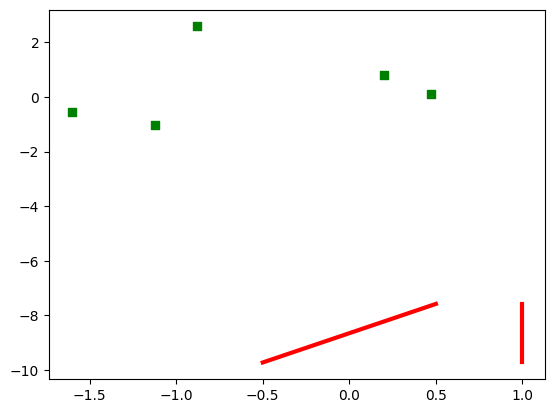

In [3]:
mu_t, sig2_t, model, h = JumpGP_LD(x,y,x0,'CEM',1)

In [4]:
xt = x0
plt.imshow(np.reshape(y, (L, L)), cmap='gray', extent=(gx[0], gx[-1], gx[0], gx[-1]))

# 绘制局部训练点
plt.scatter(x[:, 0], x[:, 1], color='r', marker='+', s=100, label='Local Training Inputs')

# 绘制测试点
plt.scatter(xt[0,0], xt[0,1], color='c', marker='o', s=100, label='Test Point')

current_ax = plt.gca()

# 函数用于复制 PathCollection
def copy_path_collection(artist, ax):
    # 获取 PathCollection 的属性
    offsets = artist.get_offsets()  # 获取点的坐标
    sizes = artist.get_sizes()  # 获取点的大小
    facecolors = artist.get_facecolor()  # 获取点的颜色
    edgecolors = artist.get_edgecolor()  # 获取边缘颜色

    # 重新绘制散点图
    return ax.scatter(offsets[:, 0], offsets[:, 1], s=sizes, c=facecolors, 
                      edgecolor=edgecolors, alpha=artist.get_alpha(), label=artist.get_label())

# 重新绘制 h3
new_artist = copy_path_collection(h[0], current_ax)
# line = h3[1][1]
# current_ax.plot(line.get_xdata(), line.get_ydata(),
#                 color=line.get_color(), linewidth=line.get_linewidth(),
#                 label=line.get_label())

# 添加图例
plt.legend()
plt.show()

NameError: name 'L' is not defined

In [3]:
xt = x0
cv = [covSum, [covSEard, covNoise]]
d = x.shape[1]  # Get the number of features (columns)
px = x
pxt = xt

# Initial estimation of the boundary B(x)
logtheta = np.zeros(d + 2)
logtheta[d + 2 - 1] = -1.15
w, _ = local_linearfit(x, y, xt)
nw = np.linalg.norm(w)
w = w / nw

# Fine-tune the intercept term
b = np.arange(-1 + w[0].item(), 1 + w[0].item() , 0.01)
fd = []
for bi in b:
    w_d = w.copy()
    w_d[0] = bi
    gx, _ = calculate_gx(px, w_d)
    r = gx >= 0
    var_r = np.var(y[r], ddof=1) if np.sum(r) > 1 else 0
    var_not_r = np.var(y[~r], ddof=1) if np.sum(~r) > 1 else 0
    fd.append(np.mean(r) * var_r + np.mean(~r) * var_not_r)

try:
    k = np.nanargmin(fd)
except:
    print("fd is all nan")
    k = 0
w[0] = b[k]
w = nw * w

In [58]:
w

array([[-0.90471592],
       [ 0.14659086],
       [ 0.27482338],
       [ 0.08776316]])

In [5]:
model = maximize_PD(x, y, xt, px, pxt, w, logtheta, cv, 1)

Initial boundary visualization


C:\Users\yxu59\autumn2024\codeBase\JumpGP_code_py\maximize_PD.py:80: RuntimeWarning: divide by zero encountered in log
  return -np.sum(r.T * np.log(1 / (1 + np.exp(-phi_w))) + (1 - r).T * np.log(1 - 1 / (1 + np.exp(-phi_w))) )
C:\Users\yxu59\autumn2024\codeBase\JumpGP_code_py\maximize_PD.py:80: RuntimeWarning: invalid value encountered in multiply
  return -np.sum(r.T * np.log(1 / (1 + np.exp(-phi_w))) + (1 - r).T * np.log(1 - 1 / (1 + np.exp(-phi_w))) )
C:\Users\yxu59\autumn2024\codeBase\JumpGP_code_py\maximize_PD.py:80: RuntimeWarning: divide by zero encountered in log
  return -np.sum(r.T * np.log(1 / (1 + np.exp(-phi_w))) + (1 - r).T * np.log(1 - 1 / (1 + np.exp(-phi_w))) )
C:\Users\yxu59\autumn2024\codeBase\JumpGP_code_py\maximize_PD.py:80: RuntimeWarning: invalid value encountered in multiply
  return -np.sum(r.T * np.log(1 / (1 + np.exp(-phi_w))) + (1 - r).T * np.log(1 - 1 / (1 + np.exp(-phi_w))) )
C:\Users\yxu59\autumn2024\codeBase\JumpGP_code_py\maximize_PD.py:80: RuntimeWarn

In [6]:
model

{'x': array([[ 9.18529459e-01,  1.32902666e-03, -2.58883649e-01],
        [ 2.13516967e-01, -4.47572462e-01, -4.94119556e-01],
        [ 6.35932005e-01,  2.23098675e+00,  2.76385170e-01],
        [-1.07645690e+00,  9.24576772e-01, -3.21494482e-01],
        [-1.84758916e-01, -9.66890382e-01, -2.72045196e-02]]),
 'y': array([[ 1.09442217],
        [-1.57575689],
        [ 0.25934436],
        [-0.24367   ],
        [ 0.6906059 ]]),
 'RR': np.float64(0.06986691736575705),
 'fs': array([[-0.91300836]]),
 'sigma': np.float64(0.25088126332820654),
 'xt': array([[ 0.35726261, -1.22451332, -1.73153892]]),
 'px': array([[ 9.18529459e-01,  1.32902666e-03, -2.58883649e-01],
        [ 2.13516967e-01, -4.47572462e-01, -4.94119556e-01],
        [ 6.35932005e-01,  2.23098675e+00,  2.76385170e-01],
        [-1.07645690e+00,  9.24576772e-01, -3.21494482e-01],
        [-1.84758916e-01, -9.66890382e-01, -2.72045196e-02]]),
 'pxt': array([[ 0.35726261, -1.22451332, -1.73153892]]),
 'nll': np.float64(1.945

In [4]:
x, y, xt, px, pxt, w, logtheta, cv

(array([[ 9.18529459e-01,  1.32902666e-03, -2.58883649e-01],
        [ 2.13516967e-01, -4.47572462e-01, -4.94119556e-01],
        [ 6.35932005e-01,  2.23098675e+00,  2.76385170e-01],
        [-1.07645690e+00,  9.24576772e-01, -3.21494482e-01],
        [-1.84758916e-01, -9.66890382e-01, -2.72045196e-02]]),
 array([[ 1.09442217],
        [-1.57575689],
        [ 0.25934436],
        [-0.24367   ],
        [ 0.6906059 ]]),
 array([[ 0.35726261, -1.22451332, -1.73153892]]),
 array([[ 9.18529459e-01,  1.32902666e-03, -2.58883649e-01],
        [ 2.13516967e-01, -4.47572462e-01, -4.94119556e-01],
        [ 6.35932005e-01,  2.23098675e+00,  2.76385170e-01],
        [-1.07645690e+00,  9.24576772e-01, -3.21494482e-01],
        [-1.84758916e-01, -9.66890382e-01, -2.72045196e-02]]),
 array([[ 0.35726261, -1.22451332, -1.73153892]]),
 array([[ 0.51083581],
        [ 0.2032643 ],
        [-0.26271854],
        [ 2.6565215 ]]),
 array([ 0.  ,  0.  ,  0.  ,  0.  , -1.15]),
 [<function cov.covSum.covSu

In [62]:
nw = np.linalg.norm(w)
w = w / nw
nIter = 100

phi_xt = np.dot(np.hstack(([1], pxt[0])), w) #phi_xt shape (1,Nt)
w = w * np.sign(phi_xt)
gx, phi_x = calculate_gx(px, w)

r = gx >= 0

In [63]:
nw,w,gx,phi_x,r

(np.float64(0.960848600567215),
 array([[ 0.9415801 ],
        [-0.15256395],
        [-0.28602152],
        [-0.09133922]]),
 array([[-5.08855783e-04],
        [ 8.98327064e-01],
        [ 5.86585088e-01],
        [ 9.96565482e-01],
        [ 8.13117594e-01]]),
 array([[ 1.        ,  1.07482595,  2.51978084,  0.62840164],
        [ 1.        , -0.19822747, -0.05086625,  0.96392588],
        [ 1.        ,  0.50753521,  0.35351684,  1.93180982],
        [ 1.        , -1.2529568 ,  0.71064681, -0.73451056],
        [ 1.        , -1.94048102,  1.13218679,  1.10226659]]),
 array([[False],
        [ True],
        [ True],
        [ True],
        [ True]]))

In [73]:
def negloglikelihood(logtheta, covfunc1, covfunc2, x, y, nargout=1):
    return -loglikelihood(logtheta, covfunc1, covfunc2, x, y, nargout)

In [102]:
logtheta = np.zeros(d + 2)
logtheta[d + 2 - 1] = -1.15

r1 = r.flatten()
ms = np.mean(y[r1]).item()
try:
    logtheta = minimize(loglikelihood, logtheta, args=(covSum, [covSEard, covNoise], x[r1,:], y[r1] - ms), options={'maxiter': nIter}).x
except:
    print(f"we fail at iteration {k}")
    err_flag = True

In [103]:
ms, logtheta

(-0.4506074461820338,
 array([15.32934822,  4.66800759, -1.17070281, -1.31294752, -1.71196093]))

In [109]:
logtheta = np.array([1.6032, 0.8211, -1.2560, -1.2075, -2.0838])

In [110]:
K = covSum([covSEard, covNoise], logtheta, x[r1,:])
_, Kt = covSum([covSEard, covNoise], logtheta, x[r1,:], x)
L = cholesky(K, lower=True)
Ly = np.linalg.solve(L, y[r1] - ms)
LK = np.linalg.solve(L, Kt)
fs = np.dot(LK.T, Ly) + ms

sigma = np.sqrt(np.mean((y[r1] - fs[r1]) ** 2))

like = norm.pdf(y, loc=fs, scale=sigma)
RR = norm.pdf(2.5 * sigma, loc=0, scale=sigma)
prior_z = 1 / (1 + np.exp(-0.05 * nw * gx))
prior_z = prior_z.reshape(-1,1)
pos_z = prior_z * like / (prior_z * like + (1 - prior_z) * RR)

r = pos_z >= 0.5

In [175]:
def wfun(wo):
    phi_w = np.dot(phi_x, wo)
    return -np.sum(r.T * np.log(1 / (1 + np.exp(-phi_w))) + (1 - r).T * np.log(1 - 1 / (1 + np.exp(-phi_w))) )
from scipy.optimize import LinearConstraint
lc = LinearConstraint(-np.array([1, *pxt.flatten()]), ub=0)

w_flattened = w.ravel()
constraints = {'type': 'ineq', 'fun': lambda wo: np.dot(np.array([1, *pxt.flatten()]), wo)}  # -[1, pxt]
w_new = minimize(wfun, w_flattened, constraints=lc, options={'disp': False}).x
# w_new = minimize(wfun, w_flattened, constraints=constraints, options={'disp': False}, method='SLSQP').x
# w_new = minimize(wfun, w_flattened, options={'disp': False}).x
# w_new = minimize(wfun, w_flattened, bounds=[(-np.inf, np.inf)], method='SLSQP').x
# w_new = w_new.reshape(w.shape)
conv_crit = np.linalg.norm(w_new / np.linalg.norm(w_new) - w / np.linalg.norm(w))

In [176]:
conv_crit

np.float64(2.839734273951422)

In [177]:
np.round(w_new,4)

array([ 10.1364, -11.5609,  -7.656 ,   7.6179])

In [170]:
wfun(w_new)

np.float64(1.3963175195485557e-06)

In [171]:
np.dot(np.array([1, *pxt.flatten()]),w_new)

np.float64(5.466491254517345)

In [160]:
np.dot(np.array([1, *pxt.flatten()]), w_new)

np.float64(5.466491254517345)

## JumpGP_QD

In [7]:
xt = x0

In [87]:
import local_qfit
import JumpGP_QD

import importlib
importlib.reload(JumpGP_QD)

from local_qfit import local_qfit
from JumpGP_QD import JumpGP_QD

In [88]:
x.shape,y.shape,xt.shape

((100, 2), (100, 1), (1, 2))

Initial boundary visualization


C:\Users\yxu59\autumn2024\codeBase\JumpGP_code_py\maximize_PD.py:80: RuntimeWarning: divide by zero encountered in log
  return -np.sum(r.T * np.log(1 / (1 + np.exp(-phi_w))) + (1 - r).T * np.log(1 - 1 / (1 + np.exp(-phi_w))) )
C:\Users\yxu59\autumn2024\codeBase\JumpGP_code_py\maximize_PD.py:80: RuntimeWarning: invalid value encountered in multiply
  return -np.sum(r.T * np.log(1 / (1 + np.exp(-phi_w))) + (1 - r).T * np.log(1 - 1 / (1 + np.exp(-phi_w))) )
C:\Users\yxu59\autumn2024\codeBase\JumpGP_code_py\maximize_PD.py:80: RuntimeWarning: divide by zero encountered in log
  return -np.sum(r.T * np.log(1 / (1 + np.exp(-phi_w))) + (1 - r).T * np.log(1 - 1 / (1 + np.exp(-phi_w))) )
C:\Users\yxu59\autumn2024\codeBase\JumpGP_code_py\maximize_PD.py:80: RuntimeWarning: invalid value encountered in multiply
  return -np.sum(r.T * np.log(1 / (1 + np.exp(-phi_w))) + (1 - r).T * np.log(1 - 1 / (1 + np.exp(-phi_w))) )
C:\Users\yxu59\autumn2024\codeBase\JumpGP_code_py\maximize_PD.py:80: RuntimeWarn

Plotting results for mode: CEM


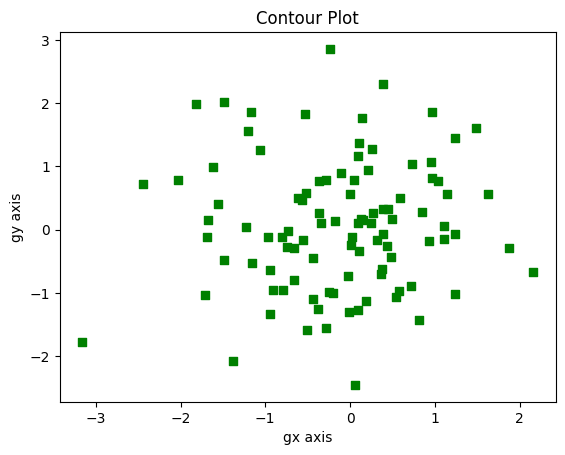

(array([[-0.1513]]),
 array([[0.7962]]),
 {'x': array([[-1.2252,  0.037 ],
         [-0.3605,  0.7771],
         [-0.8078, -0.1129],
         [-1.715 , -1.037 ],
         [-0.6097,  0.5071],
         [ 2.1619, -0.665 ],
         [-1.2092,  1.5548],
         [-0.7409, -0.277 ],
         [ 0.9713,  1.8679],
         [-0.1957, -0.9932],
         [-1.5562,  0.4005],
         [ 0.5004,  0.1736],
         [-0.5658,  0.4619],
         [ 0.1075, -0.3386],
         [ 1.4918,  1.6106],
         [-1.381 , -2.0782],
         [ 1.1071, -0.1479],
         [ 1.7589,  1.7174],
         [ 0.156 ,  0.1611],
         [-0.559 , -0.1652],
         [ 0.1836, -1.1254],
         [ 0.5778, -0.964 ],
         [-1.4855, -0.4785],
         [-3.1586, -1.7771],
         [ 0.5451, -1.0706],
         [-1.1671,  1.8684],
         [-0.2865, -1.5572],
         [-0.5067, -1.5925],
         [ 1.1144,  0.0637],
         [-0.5283,  1.8245],
         [ 1.236 , -1.0119],
         [ 0.0963, -1.265 ],
         [ 0.7211, -0.8859

In [89]:
xt = x0
JumpGP_QD(x,y,xt,'CEM',1)

In [75]:
x, y, xt, mode, bVerbose = x,y,xt,'CEM',1
cv = [covSum, [covSEard, covNoise]]
d = x.shape[1]
g1, g2 = np.meshgrid(np.arange(d), np.arange(d))
g1, g2 = g1.flatten(order='F'), g2.flatten(order='F')
id_mask = g1 >= g2

px = np.hstack([x, (x[:, g1[id_mask]] * x[:, g2[id_mask]])])
pxt = np.hstack([xt, (xt[:, g1[id_mask]] * xt[:, g2[id_mask]])])

# Initial estimation of boundary B(x)
logtheta = np.zeros(d + 2)
logtheta[-1] = -1.15
w, _ = local_qfit(x, y, xt)
nw = np.linalg.norm(w)
w /= nw

# Fine-tune intercept term
b_range = np.arange(-0.2 + w[0], 0.2 + w[0], 0.0005)
fd = []
for b_k in b_range:
    w_d = np.copy(w)
    w_d[0] = b_k
    gx, _ = calculate_gx(px, w_d)
    r = gx >= 0
    r1 = r.flatten()
    fd.append(loglikelihood(logtheta, covSum, [covSEard, covNoise], x[r1,:], y[r1]) + loglikelihood(logtheta, covSum, [covSEard, covNoise], x[~r1,:], y[~r1]))

w[0] = b_range[np.argmin(fd)]
w *= nw

if mode == 'CEM':
    model = maximize_PD(x, y, xt, px, pxt, w, logtheta, None, bVerbose)
elif mode == 'VEM':
    model = variationalEM(x, y, xt, px, pxt, w, logtheta, None, bVerbose)
elif mode == 'SEM':
    model = stochasticEM(x, y, xt, px, pxt, w, logtheta, None, bVerbose)
else:
    raise ValueError("Invalid mode specified. Choose from 'CEM', 'VEM', or 'SEM'.")

mu_t = model['mu_t']
sig2_t = model['sig2_t']

C:\Users\yxu59\AppData\Local\Temp\ipykernel_4252\126336772.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  b_range = np.arange(-0.2 + w[0], 0.2 + w[0], 0.0005)


Initial boundary visualization


In [76]:
gx_range = np.linspace(0, 1, int(1 / 0.025)) - 0.5
ptx, pty = np.meshgrid(gx_range, gx_range)
allx = np.hstack([ptx.ravel().reshape(-1, 1), pty.ravel().reshape(-1, 1)])
allx = np.hstack([allx, (allx[:, g1[id_mask]] * allx[:, g2[id_mask]])])
gx, _ = calculate_gx(allx, model['w'])
gy = np.sign(gx)

In [79]:
gy.shape

(1600,)

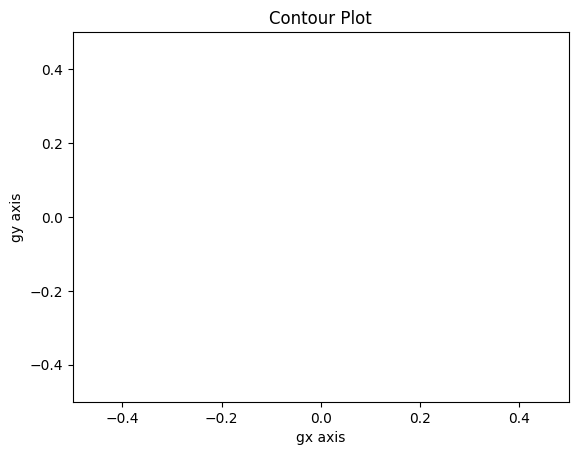

In [81]:
import numpy as np
import matplotlib.pyplot as plt

# 假设 gx 和 gy 已经定义，并且 L 是已知的
# gx = ...
# gy = ...
# L = ...

# 将 gy 重新形状为 LxL
L = len(gx_range)
gy_reshaped = np.reshape(gy, (L, L))

# 绘制等高线
plt.contour(gx_range, gx_range, gy_reshaped, levels=[1], colors='r', linewidths=3)
gx,_ = calculate_gx(px, model.w)  # 调用计算函数

# 使用布尔索引筛选 x 中的行
x_filtered = x[gx >= 0]

# 绘制散点图
h2 = plt.scatter(x_filtered[:, 0], x_filtered[:, 1], color='g', marker='s')

# 添加标题和标签
plt.title('Contour Plot')
plt.xlabel('gx axis')
plt.ylabel('gy axis')

# 显示图形
plt.show()


In [55]:
d = x.shape[1]
g1, g2 = np.meshgrid(np.arange(d), np.arange(d))
g1, g2 = g1.flatten(order='F'), g2.flatten(order='F')
id_mask = g1 >= g2

px = np.hstack([x, (x[:, g1[id_mask]] * x[:, g2[id_mask]])])
pxt = np.hstack([xt, (xt[:, g1[id_mask]] * xt[:, g2[id_mask]])])

# Initial estimation of boundary B(x)
logtheta = np.zeros(d + 2)
logtheta[-1] = -1.15
w,_ = local_qfit(x, y, xt)
nw = np.linalg.norm(w)
w /= nw

In [56]:
w

array([[ 0.178 ],
       [ 0.0741],
       [-0.01  ],
       [ 0.3844],
       [-0.1481],
       [ 0.2127],
       [ 0.2973],
       [-0.246 ],
       [-0.7711],
       [-0.0662]])

In [11]:
x0, y0, xt = x,y,xt

In [44]:
N, p = x0.shape

# Calculate differences between x0 and xt
d = x0 - xt
d2 = np.sum(d ** 2, axis=1)

# Bandwidth for Gaussian kernel
h = np.max(np.sqrt(d2))

# Gaussian kernel weights
Kh = np.exp(-0.5 * d2 / (h ** 2)) / (2 * np.pi * (h ** 2))

# Construct the local linear basis matrix
g1, g2 = np.meshgrid(np.arange(p), np.arange(p))
g1, g2 = g1.flatten(order='F'), g2.flatten(order='F')
id_mask = g1 >= g2

In [38]:
Kh

array([0.01924727, 0.01661828, 0.01815097, 0.01683869, 0.0198405 ])

In [39]:
(x0[:, g1[id_mask]] * x0[:, g2[id_mask]])

array([[ 2.93373393e-01,  1.08294472e+00, -1.82751285e-01,
         3.99753115e+00, -6.74599486e-01,  1.13841381e-01],
       [ 6.45647864e+00,  2.98237980e+00,  7.79860884e-01,
         1.37762235e+00,  3.60233725e-01,  9.41973222e-02],
       [ 2.67886464e-03, -1.22674196e-03,  8.09965834e-02,
         5.61766286e-04, -3.70910520e-02,  2.44896529e+00],
       [ 2.99378685e+00, -1.35922838e+00,  7.13887832e-01,
         6.17111994e-01, -3.24116794e-01,  1.70231169e-01],
       [ 6.10911252e-01, -5.16439884e-01, -8.61478320e-01,
         4.36577577e-01,  7.28259240e-01,  1.21481622e+00]])

In [45]:
X = np.hstack([np.ones((N, 1)), x0, (x0[:, g1[id_mask]] * x0[:, g2[id_mask]])])

# Weighted least squares
XWX = X.T @ np.diag(Kh) @ X
XWy = X.T @ np.diag(Kh) @ y0

# Solve for beta
beta = np.linalg.solve(XWX, XWy)

In [46]:
np.set_printoptions(suppress=True, precision=4)
np.round(X,4)

array([[ 1.    ,  0.5416,  1.9994, -0.3374,  0.2934,  1.0829,  3.9975,
        -0.1828, -0.6746,  0.1138],
       [ 1.    ,  2.541 ,  1.1737,  0.3069,  6.4565,  2.9824,  1.3776,
         0.7799,  0.3602,  0.0942],
       [ 1.    , -0.0518,  0.0237, -1.5649,  0.0027, -0.0012,  0.0006,
         0.081 , -0.0371,  2.449 ],
       [ 1.    , -1.7303,  0.7856, -0.4126,  2.9938, -1.3592,  0.6171,
         0.7139, -0.3241,  0.1702],
       [ 1.    ,  0.7816, -0.6607, -1.1022,  0.6109, -0.5164,  0.4366,
        -0.8615,  0.7283,  1.2148]])

In [49]:
XWy

array([[-0.0527],
       [-0.017 ],
       [-0.0041],
       [ 0.0472],
       [-0.0679],
       [ 0.0088],
       [-0.0416],
       [ 0.0134],
       [-0.0138],
       [-0.0566]])

In [91]:
percent_train=0.5
sig=2
caseno = 4  # 使用4为图8，使用6为图9
n_neighbors = 40

In [136]:
x, y, xt, yt, y0, gx, r, bw = simulate_case(caseno, sig, percent_train)
L = len(gx)

# 数据中心化
my = np.mean(yt)
y, yt, y0 = y - my, yt - my, y0 - my

# 获取边界
bw = bw.reshape(L, L)

# 定义测试点
xs_cases = {
    4: np.array([[37, 11], [36, 36], [8, 35], [17, 24], [21, 21], [34, 32]]),
    6: np.array([[27, 21], [10, 27], [37, 31], [9, 19], [21, 22], [27, 15]])
}

In [137]:
xs = xs_cases[caseno] / len(np.arange(0, 1.025, 0.025)) - 0.5

# 绘图设置
# fig, axs = plt.subplots(3, 4, figsize=(15, 15))
sel = [1, 2, 3, 6]

Initial boundary visualization
Plotting results for mode: CEM


C:\Users\yxu59\autumn2024\codeBase\JumpGP_code_py\maximize_PD.py:80: RuntimeWarning: divide by zero encountered in log
  return -np.sum(r.T * np.log(1 / (1 + np.exp(-phi_w))) + (1 - r).T * np.log(1 - 1 / (1 + np.exp(-phi_w))) )
C:\Users\yxu59\autumn2024\codeBase\JumpGP_code_py\maximize_PD.py:80: RuntimeWarning: invalid value encountered in multiply
  return -np.sum(r.T * np.log(1 / (1 + np.exp(-phi_w))) + (1 - r).T * np.log(1 - 1 / (1 + np.exp(-phi_w))) )
C:\Users\yxu59\autumn2024\codeBase\JumpGP_code_py\maximize_PD.py:80: RuntimeWarning: overflow encountered in exp
  return -np.sum(r.T * np.log(1 / (1 + np.exp(-phi_w))) + (1 - r).T * np.log(1 - 1 / (1 + np.exp(-phi_w))) )
C:\Users\yxu59\autumn2024\codeBase\JumpGP_code_py\maximize_PD.py:80: RuntimeWarning: divide by zero encountered in log
  return -np.sum(r.T * np.log(1 / (1 + np.exp(-phi_w))) + (1 - r).T * np.log(1 - 1 / (1 + np.exp(-phi_w))) )
C:\Users\yxu59\autumn2024\codeBase\JumpGP_code_py\maximize_PD.py:80: RuntimeWarning: inval

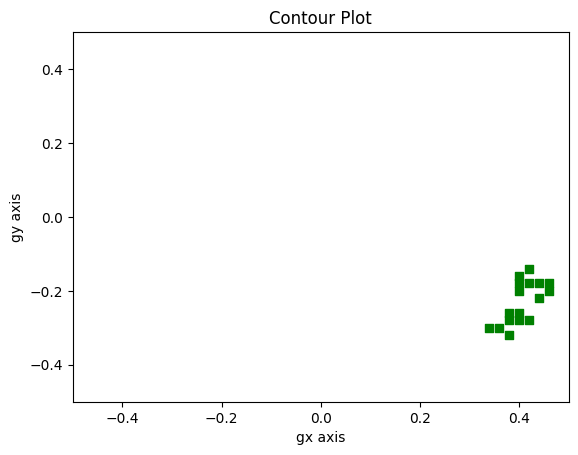

In [138]:
j = 0
k = 0 if j < 4 else 1
xt = xs[j, :]

# 找到k个最近邻
nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='auto').fit(x)
idx = nbrs.kneighbors([xt], return_distance=False)[0]
lx, ly = x[idx, :], y[idx]
ly = ly.reshape(-1, 1)
xt = xt.reshape(1, -1)

# 选择JumpGP函数
if k == 0:
    mu_t, sig2_t, model, h3 = JumpGP_QD(lx, ly, xt, 'CEM', True)
else:
    mu_t, sig2_t, model, h3 = JumpGP_QD(lx, ly, xt, 'VEM', True)

In [139]:
gx_range = np.linspace(0, 1, int(1 / 0.025)) - 0.5
ptx, pty = np.meshgrid(gx_range, gx_range)
allx = np.hstack([ptx.ravel().reshape(-1, 1), pty.ravel().reshape(-1, 1)])
allx = np.hstack([allx, (allx[:, g1[id_mask]] * allx[:, g2[id_mask]])])
gx, _ = calculate_gx(allx, model['w'])
gy = np.sign(gx)

In [141]:
gx

array([-0.3605, -0.3367, -0.3137, ...,  0.0769,  0.0845,  0.0914])

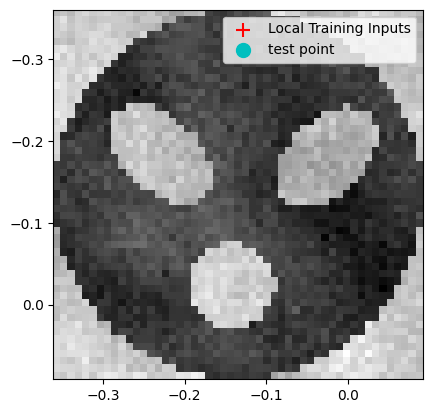

In [142]:
plt.imshow(np.reshape(yt, (L, L)), cmap='gray', extent=(gx[0], gx[-1], gx[-1], gx[0]))
plt.scatter(lx[:, 0], lx[:, 1], color='r', marker='+', s=100, label='Local Training Inputs')

plt.scatter(xt[0, 0], xt[0, 1], color='c', marker='o', s=100, label='test point')
current_ax = plt.gca()

# 函数用于复制 PathCollection
def copy_path_collection(artist, ax):
    # 获取 PathCollection 的属性
    offsets = artist.get_offsets()  # 获取点的坐标
    sizes = artist.get_sizes()  # 获取点的大小
    facecolors = artist.get_facecolor()  # 获取点的颜色
    edgecolors = artist.get_edgecolor()  # 获取边缘颜色

    # 重新绘制散点图
    return ax.scatter(offsets[:, 0], offsets[:, 1], s=sizes, c=facecolors, 
                    edgecolor=edgecolors, alpha=artist.get_alpha(), label=artist.get_label())

# 重新绘制 h3
new_artist = copy_path_collection(h3, current_ax)
# A, B, C, D, E, F = model["w"][::-1]
# ggx = np.linspace(-0.5, 0.5, 400)

# # 创建一个网格以计算 y 值
# ggX, ggY = np.meshgrid(ggx, ggx)

# # 计算椭圆方程
# Z = A * ggX**2 + B * ggX * ggY + C * ggY**2 + D * ggX + E * ggY + F
L1 = len(gx_range)
# plt.contour(gx_range, gx_range, np.reshape(gy, (L1, L1)), levels=[0], colors='r')

plt.imshow(np.reshape(yt, (L, L)), cmap='gray', extent=(gx[0], gx[-1], gx[-1], gx[0]))

# if i == 1 and k == 1:
#     ax.set_xlabel('x1')
#     ax.set_ylabel('x2')

plt.legend()
plt.show()

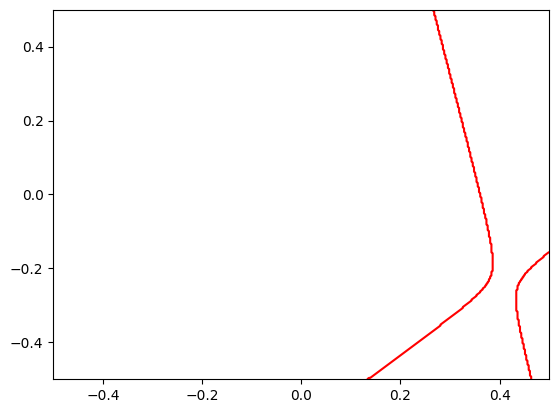

In [147]:
import numpy as np
import matplotlib.pyplot as plt

# 二次曲线系数（示例，这里假设形成一个椭圆）
A, B, C, D, E, F = 0.4519, -0.4441, 0.4603, -0.4511, 0.3488, -0.2482

# 生成 x 值
x = np.linspace(0, 1, 400) - 0.5
# gx_range = np.linspace(0, 1, int(1 / 0.025)) - 0.5
ptx, pty = np.meshgrid(x, x)
allx = np.hstack([ptx.ravel().reshape(-1, 1), pty.ravel().reshape(-1, 1)])
allx = np.hstack([allx, (allx[:, g1[id_mask]] * allx[:, g2[id_mask]])])
gx, _ = calculate_gx(allx, model['w'])
gy = np.sign(gx)
L1 = len(x)
plt.contour(x, x, np.reshape(gy, (L1, L1)), levels=[0], colors='r')

# # 创建一个网格以计算 y 值
# X, Y = np.meshgrid(x, x)

# # 计算椭圆方程
# Z = A * X**2 + B * X * Y + C * Y**2 + D * X + E * Y + F

# 绘图
# plt.figure(figsize=(10, 10))
# plt.contour(X, Y, Z, levels=[0], colors='b')  # 只绘制零级等高线
# plt.title('Quadratic Curve (Ellipse)')
# plt.xlabel('x')
# plt.ylabel('y')
# plt.axhline(0, color='black', lw=0.5, ls='--')  # 添加 y=0 参考线
# plt.axvline(0, color='black', lw=0.5, ls='--')  # 添加 x=0 参考线
# plt.grid()
# plt.axis('equal')  # 确保 x 和 y 轴等比例
plt.show()


In [114]:
(model["w"]).shape

(6,)